# Outlier analysis and anomaly detection

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from scipy import stats
from sklearn.metrics import roc_auc_score
from sklearn.utils import column_or_1d

from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.hbos import HBOS
from pyod.models.knn import KNN
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize

import warnings
warnings.filterwarnings('ignore')

## 1 skin-benchmark
### 1.1 数据集分析
在数据集的**benchmarks**目录下包含1500个**skin_benchmark**文件，每个benchmark文件中包含6000条记录，选取**R\G\B**三个属性以及**ground.truth**进行离群点分析与异常检测。

In [2]:
path = "./skin/benchmarks/"
files = []
for filename in os.listdir(path):
    file_path = os.path.join(path, filename)
    files.append(file_path)
num_files = len(files)
print("Number of benchmark files: " , num_files)

Number of benchmark files:  1500


In [3]:
print("File 0: ", files[0])
df0 = pd.read_csv(files[0])
print("DataFrame shape:", df0.shape)
df0.head()

File 0:  ./skin/benchmarks/skin_benchmark_0001.csv
DataFrame shape: (6000, 9)


,point.id,motherset,origin,original.label,diff.score,ground.truth,R,G,B
0,skin_point_117027,skin,binary,2,0.020405,nominal,-1.864336,-2.110524,-1.587289
1,skin_point_016927,skin,binary,1,0.000250,anomaly,0.384456,0.925785,1.747782
2,skin_point_240995,skin,binary,2,0.001285,nominal,-0.980882,-1.092860,-1.394351
3,skin_point_018861,skin,binary,1,0.000739,anomaly,-1.125447,-0.542320,0.383435
4,skin_point_087883,skin,binary,2,0.001053,nominal,-0.964819,-1.076177,-1.380570


### 1.2 CBLOF
CBLOF算法时基于聚类组的本地异常因子计算异常值分数。
CBLOF将数据集和由聚类算法生成的聚类模型作为输入。它使用参数alpha和beta将群集分为小群集和大群集。然后基于该点所属的聚类的大小以及到最近的大聚类的距离来计算异常分数。  

In [12]:
cblof_roc = []
for i in range(num_files):
    df = pd.read_csv(files[i])
    
    # 选取特征
    X = df[["R","G","B"]].values
    labels = np.where(df["ground.truth"] == "nominal" , 0 ,1)
    
    train_rate = 0.7
    X_train = X[:int(train_rate*len(X))]
    X_test = X[int(train_rate*len(X)):]
    y_train = labels[:int(train_rate*len(X))]
    y_test = labels[int(train_rate*len(X)):]
    
    # train CBLOF detector
    clf_name = 'CBLOF'
    clf = CBLOF(random_state=42)
    clf.fit(X_train)

    # get the prediction labels and outlier scores of the training data
    y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
    y_train_scores = clf.decision_scores_  # raw outlier scores

    # get the prediction on the test data
    y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
    y_test_scores = clf.decision_function(X_test)  # outlier scores
    
    y = column_or_1d(y_test)
    y_pred = column_or_1d(y_test_scores)
    try:
        roc = np.round(roc_auc_score(y, y_pred), decimals=4)
        cblof_roc.append(roc)
    except ValueError:
        pass
    # cblof_roc.append(roc)
    
    if i % 1000 == 0:
        # evaluate and print the results
        print("\nOn Training Data:")
        evaluate_print(clf_name, y_train, y_train_scores)
        print("\nOn Test Data:")
        evaluate_print(clf_name, y_test, y_test_scores)


On Training Data:
CBLOF ROC:0.6643, precision @ rank n:0.301

On Test Data:
CBLOF ROC:0.678, precision @ rank n:0.3394

On Training Data:
CBLOF ROC:0.7514, precision @ rank n:0.0

On Test Data:
CBLOF ROC:0.7158, precision @ rank n:0.0


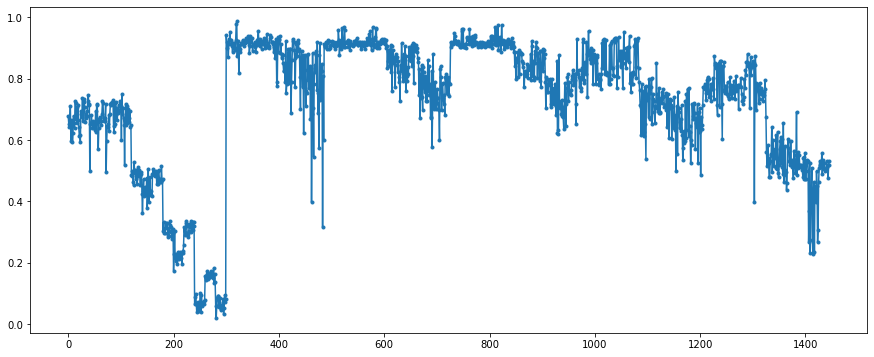

In [13]:
plt.figure(figsize=(15, 6))
x_data = [x for x in range(len(cblof_roc))]
plt.plot(x_data, cblof_roc, '.-')
plt.show()

### 1.3 HBOS
基于直方图的离群值检测（HBOS）是一种有效的无监督方法。它假设特征独立并通过构建直方图来计算异常程度， 在多变量异常检测中，可以计算每个单个特征的直方图，单独评分并在最后组合。 使用PyOD库时，其代码与CBLOF类似。  

In [11]:
hbos_roc = []
for i in range(num_files):
    df = pd.read_csv(files[i])
    
    # 选取特征
    X1 = df['R'].values.reshape(-1,1)
    X2 = df['G'].values.reshape(-1,1)
    X3 = df['B'].values.reshape(-1,1)
    X = np.concatenate((X1, X2, X3),axis=1)
    labels = np.where(df["ground.truth"] == "nominal" , 0 ,1)
    
    train_rate = 0.7
    X_train = X[:int(train_rate*len(X))]
    X_test = X[int(train_rate*len(X)):]
    y_train = labels[:int(train_rate*len(X))]
    y_test = labels[int(train_rate*len(X)):]
    
    # train HBOS detector
    clf_name = 'HBOS'
    clf = HBOS()
    clf.fit(X_train)

    # get the prediction labels and outlier scores of the training data
    y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
    y_train_scores = clf.decision_scores_  # raw outlier scores

    # get the prediction on the test data
    y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
    y_test_scores = clf.decision_function(X_test)  # outlier scores
    
    y = column_or_1d(y_test)
    y_pred = column_or_1d(y_test_scores)
    try:
        roc = np.round(roc_auc_score(y, y_pred), decimals=4)
        hbos_roc.append(roc)
    except ValueError:
        pass
    
    if i % 1000 == 0:
        # evaluate and print the results
        print("\nOn Training Data:")
        evaluate_print(clf_name, y_train, y_train_scores)
        print("\nOn Test Data:")
        evaluate_print(clf_name, y_test, y_test_scores)


On Training Data:
HBOS ROC:0.5881, precision @ rank n:0.1709

On Test Data:
HBOS ROC:0.5867, precision @ rank n:0.2016

On Training Data:
HBOS ROC:0.4226, precision @ rank n:0.0

On Test Data:
HBOS ROC:0.4002, precision @ rank n:0.0


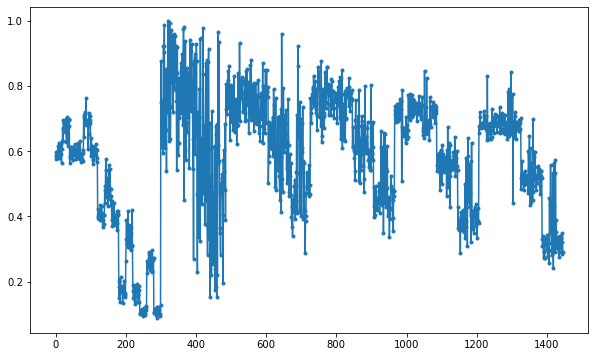

In [8]:
plt.figure(figsize=(10, 6))
x_data = [x for x in range(len(hbos_roc))]
plt.plot(x_data, hbos_roc, '.-')
plt.show()

### 1.4 KNN
用于离群检测的pyod.models.knn.KNN, 对于数据，它与第k个最近邻居的距离可以被视为异常值。它可以被视为衡量密度的一种方法。其代码与之前的CBLOF非常相似。

In [9]:
knn_roc = []
for i in range(num_files):
    df = pd.read_csv(files[i])
    
    # 选取特征
    X1 = df['R'].values.reshape(-1,1)
    X2 = df['G'].values.reshape(-1,1)
    X3 = df['B'].values.reshape(-1,1)
    X = np.concatenate((X1, X2, X3),axis=1)
    labels = np.where(df["ground.truth"] == "nominal" , 0 ,1)
    
    train_rate = 0.7
    X_train = X[:int(train_rate*len(X))]
    X_test = X[int(train_rate*len(X)):]
    y_train = labels[:int(train_rate*len(X))]
    y_test = labels[int(train_rate*len(X)):]
    
    # train KNN detector
    clf_name = 'KNN'
    clf = KNN()
    clf.fit(X_train)

    # get the prediction labels and outlier scores of the training data
    y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
    y_train_scores = clf.decision_scores_  # raw outlier scores

    # get the prediction on the test data
    y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
    y_test_scores = clf.decision_function(X_test)  # outlier scores
    
    y = column_or_1d(y_test)
    y_pred = column_or_1d(y_test_scores)
    try:
        roc = np.round(roc_auc_score(y, y_pred), decimals=4)
        knn_roc.append(roc)
    except ValueError:
        pass
    
    if i % 1000 == 0:
        # evaluate and print the results
        print("\nOn Training Data:")
        evaluate_print(clf_name, y_train, y_train_scores)
        print("\nOn Test Data:")
        evaluate_print(clf_name, y_test, y_test_scores)


On Training Data:
KNN ROC:0.7189, precision @ rank n:0.2122

On Test Data:
KNN ROC:0.7225, precision @ rank n:0.2715

On Training Data:
KNN ROC:0.955, precision @ rank n:0.0426

On Test Data:
KNN ROC:0.9322, precision @ rank n:0.0769


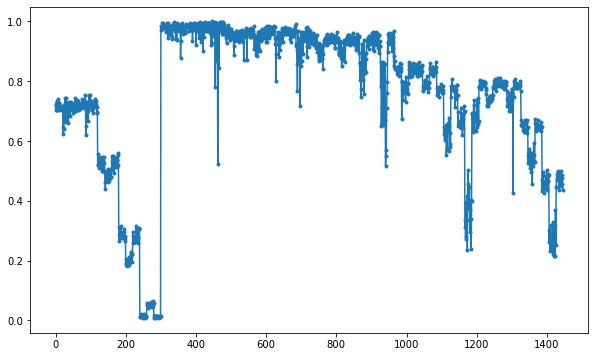

In [10]:
plt.figure(figsize=(10, 6))
x_data = [x for x in range(len(knn_roc))]
plt.plot(x_data, knn_roc, '.-')
plt.show()

### 1.5 对比
根据柱状图我们可以看出，总体来说**KNN**的表现结果最好，其计算消耗时间也更长。

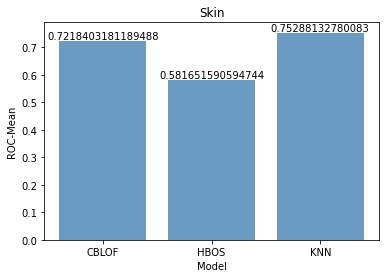

In [14]:
x = ['CBLOF', 'HBOS', 'KNN']
y = [np.mean(cblof_roc), np.mean(hbos_roc), np.mean(knn_roc)]
plt.bar(x=x, height=y, label='ROC', color='steelblue', alpha=0.8)
# 在柱状图上显示具体数值, ha参数控制水平对齐方式, va控制垂直对齐方式
for x1, yy in zip(x, y):
    plt.text(x1, yy, str(yy), ha='center', va='bottom', fontsize=10, rotation=0)
plt.title("Skin")
plt.xlabel("Model")
plt.ylabel("ROC-Mean")
plt.show()

## 2 abalone-benchmark
### 2.1 数据集分析
在数据集的**benchmarks**目录下包含1725个**skin_benchmark**文件，每个benchmark文件中包含1888条记录，选取**V1-V7**七个属性以及**ground.truth**进行离群点分析与异常检测。

In [15]:
path = "./abalone/benchmarks/"
files = []
for filename in os.listdir(path):
    file_path = os.path.join(path, filename)
    files.append(file_path)
num_files = len(files)
print("Number of benchmark files: " , num_files)

Number of benchmark files:  1725


In [16]:
print("File 0: ", files[0])
df0 = pd.read_csv(files[0])
print("DataFrame shape:", df0.shape)
df0.head()

File 0:  ./abalone/benchmarks/abalone_benchmark_0001.csv
DataFrame shape: (1888, 13)


,point.id,motherset,origin,original.label,diff.score,ground.truth,V1,V2,V3,V4,V5,V6,V7
0,abalone_point_1584,abalone,regression,7,0.153312,nominal,-0.116511,-0.129799,-0.227518,-0.461352,-0.353066,-0.342963,-0.551935
1,abalone_point_0315,abalone,regression,23,0.202253,anomaly,0.882716,0.777094,0.848341,0.960988,0.333986,1.039157,1.588828
2,abalone_point_1779,abalone,regression,8,0.562701,nominal,-0.283048,-0.532863,0.489721,0.103505,-0.048961,0.313886,0.313709
3,abalone_point_1926,abalone,regression,11,0.209155,anomaly,0.716178,0.625945,0.609261,0.713225,0.930932,0.893190,0.396322
4,abalone_point_0588,abalone,regression,13,0.163268,anomaly,0.216565,0.021350,0.131102,-0.000494,-0.224666,0.090375,0.080237


进一步提取特征：

### 2.2 CBLOF

In [18]:
cblof_roc = []
for i in range(num_files):
    df = pd.read_csv(files[i])
    
    # 选取特征
    X = df[["V1","V2","V3", "V4", "V5", "V6", "V7"]].values
    labels = np.where(df["ground.truth"] == "nominal" , 0 ,1)
    
    train_rate = 0.7
    X_train = X[:int(train_rate*len(X))]
    X_test = X[int(train_rate*len(X)):]
    y_train = labels[:int(train_rate*len(X))]
    y_test = labels[int(train_rate*len(X)):]
    
    # train CBLOF detector
    clf_name = 'CBLOF'
    clf = CBLOF(random_state=42)
    clf.fit(X_train)

    # get the prediction labels and outlier scores of the training data
    y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
    y_train_scores = clf.decision_scores_  # raw outlier scores

    # get the prediction on the test data
    y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
    y_test_scores = clf.decision_function(X_test)  # outlier scores
    
    y = column_or_1d(y_test)
    y_pred = column_or_1d(y_test_scores)
    try:
        roc = np.round(roc_auc_score(y, y_pred), decimals=4)
        cblof_roc.append(roc)
    except ValueError:
        pass
    
    if i % 1000 == 0:
        # evaluate and print the results
        print("\nOn Training Data:")
        evaluate_print(clf_name, y_train, y_train_scores)
        print("\nOn Test Data:")
        evaluate_print(clf_name, y_test, y_test_scores)


On Training Data:
CBLOF ROC:0.576, precision @ rank n:0.5394

On Test Data:
CBLOF ROC:0.5911, precision @ rank n:0.5376

On Training Data:
CBLOF ROC:0.829, precision @ rank n:0.125

On Test Data:
CBLOF ROC:0.629, precision @ rank n:0.0


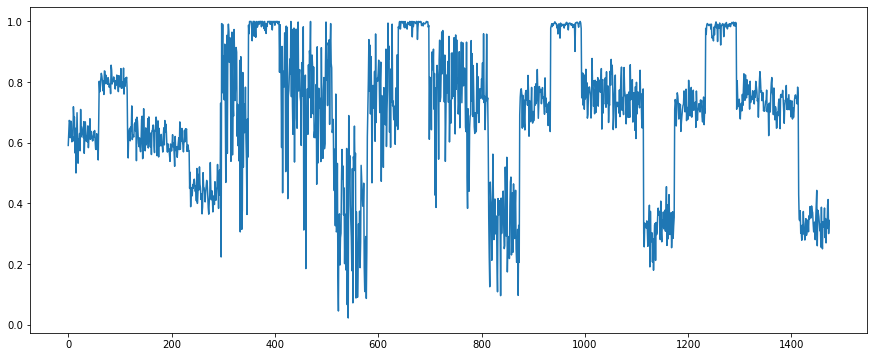

In [19]:
plt.figure(figsize=(15, 6))
x_data = [x for x in range(len(cblof_roc))]
plt.plot(x_data, cblof_roc)
plt.show()

### 2.3 HBOS

In [21]:
hbos_roc = []
for i in range(num_files):
    df = pd.read_csv(files[i])
    
    # 选取特征
    X = df[["V1","V2","V3", "V4", "V5", "V6", "V7"]].values
    labels = np.where(df["ground.truth"] == "nominal" , 0 ,1)
    
    train_rate = 0.7
    X_train = X[:int(train_rate*len(X))]
    X_test = X[int(train_rate*len(X)):]
    y_train = labels[:int(train_rate*len(X))]
    y_test = labels[int(train_rate*len(X)):]
    
    # train HBOS detector
    clf_name = 'HBOS'
    clf = HBOS()
    clf.fit(X_train)

    # get the prediction labels and outlier scores of the training data
    y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
    y_train_scores = clf.decision_scores_  # raw outlier scores

    # get the prediction on the test data
    y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
    y_test_scores = clf.decision_function(X_test)  # outlier scores
    
    y = column_or_1d(y_test)
    y_pred = column_or_1d(y_test_scores)
    try:
        roc = np.round(roc_auc_score(y, y_pred), decimals=4)
        hbos_roc.append(roc)
    except ValueError:
        pass
    
    if i % 1000 == 0:
        # evaluate and print the results
        print("\nOn Training Data:")
        evaluate_print(clf_name, y_train, y_train_scores)
        print("\nOn Test Data:")
        evaluate_print(clf_name, y_test, y_test_scores)


On Training Data:
HBOS ROC:0.4496, precision @ rank n:0.4302

On Test Data:
HBOS ROC:0.4736, precision @ rank n:0.4488

On Training Data:
HBOS ROC:0.8497, precision @ rank n:0.1875

On Test Data:
HBOS ROC:0.4749, precision @ rank n:0.0


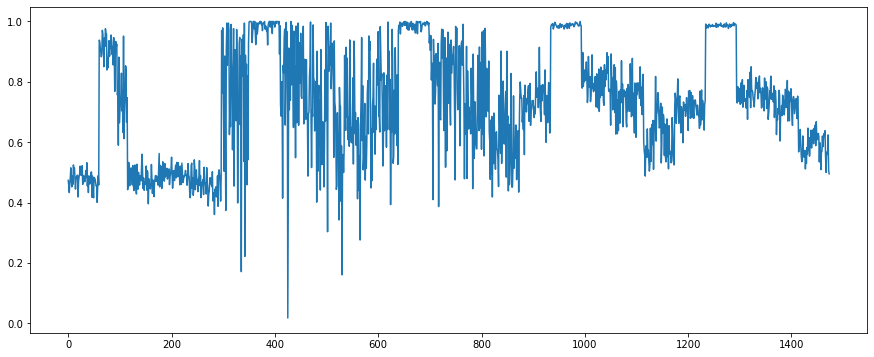

In [22]:
plt.figure(figsize=(15, 6))
x_data = [x for x in range(len(hbos_roc))]
plt.plot(x_data, hbos_roc)
plt.show()

### 2.4 KNN

In [23]:
knn_roc = []
for i in range(num_files):
    df = pd.read_csv(files[i])
    
    # 选取特征
    X = df[["V1","V2","V3", "V4", "V5", "V6", "V7"]].values
    labels = np.where(df["ground.truth"] == "nominal" , 0 ,1)
    
    train_rate = 0.7
    X_train = X[:int(train_rate*len(X))]
    X_test = X[int(train_rate*len(X)):]
    y_train = labels[:int(train_rate*len(X))]
    y_test = labels[int(train_rate*len(X)):]
    
    # train KNN detector
    clf_name = 'KNN'
    clf = KNN()
    clf.fit(X_train)

    # get the prediction labels and outlier scores of the training data
    y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
    y_train_scores = clf.decision_scores_  # raw outlier scores

    # get the prediction on the test data
    y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
    y_test_scores = clf.decision_function(X_test)  # outlier scores
    
    y = column_or_1d(y_test)
    y_pred = column_or_1d(y_test_scores)
    try:
        roc = np.round(roc_auc_score(y, y_pred), decimals=4)
        knn_roc.append(roc)
    except ValueError:
        pass
    
    if i % 1000 == 0:
        # evaluate and print the results
        print("\nOn Training Data:")
        evaluate_print(clf_name, y_train, y_train_scores)
        print("\nOn Test Data:")
        evaluate_print(clf_name, y_test, y_test_scores)


On Training Data:
KNN ROC:0.7643, precision @ rank n:0.6893

On Test Data:
KNN ROC:0.7716, precision @ rank n:0.6917

On Training Data:
KNN ROC:0.859, precision @ rank n:0.125

On Test Data:
KNN ROC:0.7676, precision @ rank n:0.0


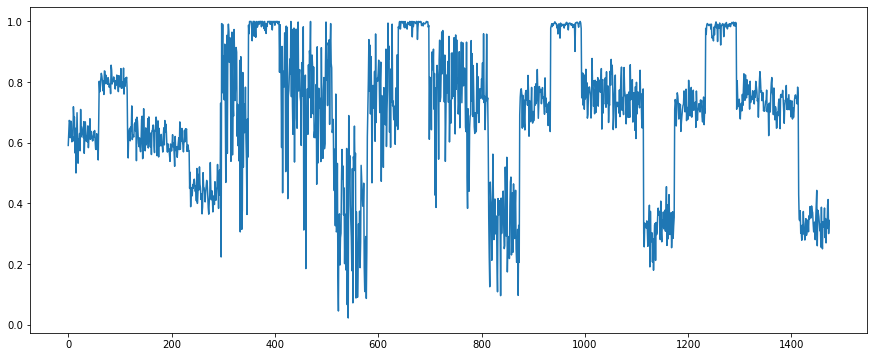

In [24]:
plt.figure(figsize=(15, 6))
x_data = [x for x in range(len(cblof_roc))]
plt.plot(x_data, cblof_roc)
plt.show()

### 2.5 对比
根据柱状图我们可以看出，在abalone这样的高维数据集上，依旧是**KNN**的表现结果最好。同时，HBOS方法也表现出了较好的异常点检测能力。

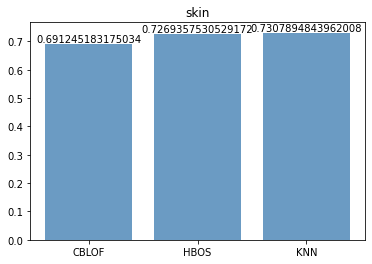

In [25]:
x = ['CBLOF', 'HBOS', 'KNN']
y = [np.mean(cblof_roc), np.mean(hbos_roc), np.mean(knn_roc)]
plt.bar(x=x, height=y, label='ROC', color='steelblue', alpha=0.8)
# 在柱状图上显示具体数值, ha参数控制水平对齐方式, va控制垂直对齐方式
for x1, yy in zip(x, y):
    plt.text(x1, yy, str(yy), ha='center', va='bottom', fontsize=10, rotation=0)
# 设置标题
plt.title("skin")
plt.show()